# Reinforcement learning anaysis

*Hypothesis*: the exploitation budget of Zeph will be responsible of the most part of nodes and links discoveries. 

In [1]:
from pathlib import Path

experiment = "exp1"
sub_experiment = "zeph_25"

# Directory of the experiment
exp_dir = Path(f"../resources/data/measurements/{experiment}/")

# Directory of the total prefixes and exploitation prefixes pickle files
prefixes_dir = exp_dir / "prefixes"
exploitation_dir = exp_dir / "exploitation"

In [2]:
import pickle
from pathlib import Path

with (exp_dir / f"{sub_experiment}.txt").open("r") as fd:
    experiment_uuids = [uuid.strip() for uuid in fd.readlines()]

In [3]:
# Get Iris API / database credentials
import json
from zeph.drivers import create_auth_header, get_database_url

config = json.load(open("../config.json"))
headers = create_auth_header(config["iris_url"], config["iris_username"], config["iris_password"])
database_url = get_database_url(config["iris_url"], headers)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Links

In [5]:
import orjson
import requests

from dataclasses import dataclass
from typing import Sequence, Iterator, Iterable

from diamond_miner.queries.query import UNIVERSE_SUBSET, LinksQuery, links_table
from diamond_miner.typing import IPNetwork

@dataclass(frozen=True)
class GetLinksPrefixes(LinksQuery):
    """
    Return the links pre-computed in the links table.
    This doesn't group replies by probe protocol and probe source address,
    in other words, it assumes that the table contains the replies for a
    single vantage point and a single protocol.
    """

    def prefix_v4_to_v6(self, prefix):
        return "::ffff:" + str(prefix.network_address) 

    def group_elements(self, l, n):
        return [l[i:i + n] for i in range(0, len(l), n)]

    def execute_iter(
        self,
        url: str,
        measurement_id: str,
        prefixes,
        n_chunks,
        *,
        data  = None,
        limit  = None,
        subsets = (UNIVERSE_SUBSET,),
        timeout  = (1, 60),
    ) -> Iterator:
        prefixes_chunks = self.group_elements(list(prefixes), n_chunks)
        for prefixes in prefixes_chunks:
            for _, statement in enumerate(self.statements(measurement_id, prefixes)):
                    params = {
                        "default_format": "JSONEachRow",
                        "limit": limit[0] if limit else 0,
                        "offset": limit[1] if limit else 0,
                        "output_format_json_quote_64bit_integers": 0,
                        "query": statement,
                    }
                    r = requests.post(
                        url,
                        headers={"Accept-encoding": "gzip"},
                        params=params,
                        data=data,
                        stream=True,
                        timeout=timeout,
                    )
                    try:
                        for line in r.iter_lines(chunk_size=2 ** 20):
                            yield orjson.loads(line)
                    except orjson.JSONDecodeError as e:
                        raise RuntimeError(f"Invalid database response: {line}") from e

    def statements(
        self, measurement_id: str, prefixes: Iterable[IPNetwork]
    ) -> Sequence[str]:
        # Override this method if you want your query to return multiple statements.
        return (self.statement(measurement_id, prefixes),)

    def statement(
        self, measurement_id: str, prefixes: Iterable[IPNetwork]
    ) -> str:
        q =  f"""
        SELECT DISTINCT near_addr, far_addr
        FROM {links_table(measurement_id)}
        WHERE {self.filters(UNIVERSE_SUBSET)}
        AND probe_dst_prefix IN [
        """
        q += ",".join([f"toIPv6('{self.prefix_v4_to_v6(prefix)}')" for prefix in prefixes])
        q += "]"
        return q

In [6]:
def get_links_exploitation(measurement_id, prefixes, n_chunks):
    distinct_links = set()
    for link in GetLinksPrefixes().execute_iter(database_url, measurement_id, prefixes, n_chunks):
        distinct_links.add((link["near_addr"], link["far_addr"])) 
    return distinct_links

In [7]:
from diamond_miner.queries import GetLinks
from zeph.drivers import get_previous_measurement_agents

def sanitize_uuid(uuid):
    return str(uuid).replace("-", "_")

def get_links_total(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(config["iris_url"], measurement_uuid, headers)
    
    distinct_links = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for link in GetLinks().execute_iter(database_url, measurement_id):
            distinct_links.add((link["near_addr"], link["far_addr"])) 
    return distinct_links

In [8]:
# Estimated computing time: ~2 minutes

total_n_links = []
for uuid in experiment_uuids:
    total_n_links.append(len(get_links_total(uuid)))

print(total_n_links)

[1462889, 1717638, 1881807, 2003898, 2056546, 2082815, 2074676, 2056853, 2030392, 2097882]

In [9]:
# Estimated computing time: ~30 minutes

exploitation_n_links = [None]
for uuid in experiment_uuids[1:]:
    # Get exploitation prefixes 
    with (exploitation_dir / f"exploitation_{uuid}.pickle").open("rb") as fd:
        exploitation_prefixes = pickle.load(fd)
    
    cycle_n_links = set()
    for agent_uuid in exploitation_prefixes.keys():
        cycle_n_links.update(get_links_exploitation(f"{uuid}__{agent_uuid}", exploitation_prefixes[agent_uuid], 5000))
    exploitation_n_links.append(len(cycle_n_links))

print(exploitation_n_links)

[None, 1278962, 1560546, 1748593, 1862593, 1878883, 1868577, 1835564, 1815689, 1902539]

<Figure size 432x288 with 1 Axes>

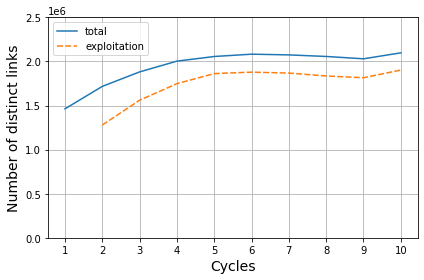

In [10]:
data = pd.DataFrame({
    "total": total_n_links,
    "exploitation": exploitation_n_links,
})

ax = sns.lineplot(data=data)

ax.set_xlabel("Cycles", fontsize=14)
ax.set_ylabel("Number of distinct links", fontsize=14)
ax.set(ylim=(0, 2_500_000))

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 10)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(1, 11)))
ax.grid()

plt.tight_layout()
plt.savefig("../resources/figures/exploitation_vs_total_links.pdf")
plt.show()

## Nodes

In [11]:
from dataclasses import dataclass
from typing import Iterable, Iterator, Sequence

from diamond_miner.queries.query import UNIVERSE_SUBSET, ResultsQuery, results_table
from diamond_miner.typing import IPNetwork

@dataclass(frozen=True)
class GetNodesPrefixes(ResultsQuery):
    def prefix_v4_to_v6(self, prefix):
        return "::ffff:" + str(prefix.network_address) 

    def group_elements(self, l, n):
        return [l[i:i + n] for i in range(0, len(l), n)]

    def execute_iter(
        self,
        url: str,
        measurement_id: str,
        prefixes,
        n_chunks,
        *,
        data  = None,
        limit  = None,
        subsets = (UNIVERSE_SUBSET,),
        timeout  = (1, 60),
    ) -> Iterator:
        prefixes_chunks = self.group_elements(list(prefixes), n_chunks)
        for prefixes in prefixes_chunks:
            for _, statement in enumerate(self.statements(measurement_id, prefixes)):
                    params = {
                        "default_format": "JSONEachRow",
                        "limit": limit[0] if limit else 0,
                        "offset": limit[1] if limit else 0,
                        "output_format_json_quote_64bit_integers": 0,
                        "query": statement,
                    }
                    r = requests.post(
                        url,
                        headers={"Accept-encoding": "gzip"},
                        params=params,
                        data=data,
                        stream=True,
                        timeout=timeout,
                    )
                    try:
                        for line in r.iter_lines(chunk_size=2 ** 20):
                            yield orjson.loads(line)
                    except orjson.JSONDecodeError as e:
                        raise RuntimeError(f"Invalid database response: {line}") from e

    def statements(
        self, measurement_id: str, prefixes: Iterable[IPNetwork]
    ) -> Sequence[str]:
        # Override this method if you want your query to return multiple statements.
        return (self.statement(measurement_id, prefixes),)

    def statement(
            self, measurement_id: str, prefixes: Iterable[IPNetwork]
        ) -> str:
            q = f"""
            SELECT reply_src_addr
            FROM {results_table(measurement_id)}
            WHERE {self.filters(UNIVERSE_SUBSET)}
            AND probe_dst_prefix IN [
            """
            q += ",".join([f"toIPv6('{self.prefix_v4_to_v6(prefix)}')" for prefix in prefixes])
            q += "]"
            return q

In [12]:
def get_nodes_exploitation(measurement_id, prefixes, n_chunks):
    distinct_nodes = set()
    for node in GetNodesPrefixes().execute_iter(database_url, measurement_id, prefixes, n_chunks):
        distinct_nodes.add(node["reply_src_addr"]) 
    return distinct_nodes

In [13]:
from diamond_miner.queries import GetNodes

def get_nodes_total(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(config["iris_url"], measurement_uuid, headers)
    
    distinct_nodes = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for node in GetNodes().execute_iter(database_url, measurement_id):
            distinct_nodes.add(node["reply_src_addr"]) 
    return distinct_nodes

In [14]:
# Estimated computing time: ~1 minute

total_n_nodes = []
for uuid in experiment_uuids:
    total_n_nodes.append(len(get_nodes_total(uuid)))

print(total_n_nodes)

[739755, 839275, 877413, 903131, 916350, 920832, 919425, 919637, 914434, 921358]

In [15]:
# Estimated computing time: ~30 minutes

exploitation_n_nodes = [None]
for uuid in experiment_uuids[1:]:
    uuid = uuid.strip()
    # Get exploitation prefixes 
    with (exploitation_dir / f"exploitation_{uuid}.pickle").open("rb") as fd:
        exploitation_prefixes = pickle.load(fd)
    
    cycle_n_nodes = set()
    for agent_uuid in exploitation_prefixes.keys():
        cycle_n_nodes.update(get_nodes_exploitation(f"{uuid}__{agent_uuid}", exploitation_prefixes[agent_uuid], 5000))
    exploitation_n_nodes.append(len(cycle_n_nodes))

print(exploitation_n_nodes)

[None, 688713, 793993, 843963, 868476, 877259, 876527, 871520, 869851, 881423]

<Figure size 432x288 with 1 Axes>

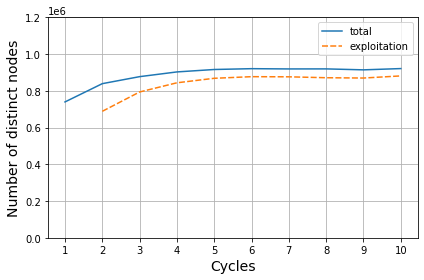

In [16]:
data = pd.DataFrame({
    "total": total_n_nodes,
    "exploitation": exploitation_n_nodes,
})

ax = sns.lineplot(data=data)

ax.set_xlabel("Cycles", fontsize=14)
ax.set_ylabel("Number of distinct nodes", fontsize=14)
ax.set(ylim=(0, 1_200_000))

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 10)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(1, 11)))
ax.grid()

plt.tight_layout()
plt.savefig("../resources/figures/exploitation_vs_total_nodes.pdf")
plt.show()

## Budget

In [17]:
# Estimated computing time: ~25 minutes

exploitation_prefixes_ratio = [0]
for uuid in experiment_uuids[1:]:
    # Get total prefixes 
    with (prefixes_dir / f"prefixes_{uuid}.pickle").open("rb") as fd:
        total_prefixes = pickle.load(fd)
    total_n_prefixes = len(set.union(*[set(s) for s in total_prefixes.values()]))

    # Get exploitation prefixes 
    with (exploitation_dir / f"exploitation_{uuid}.pickle").open("rb") as fd:
        exploitation_prefixes = pickle.load(fd)
    exploitation_n_prefixes = len(set.union(*exploitation_prefixes.values()))

    exploitation_prefixes_ratio.append(exploitation_n_prefixes / total_n_prefixes)

print(exploitation_prefixes_ratio)

[
    0,
    0.08581165446929756,
    0.0968299158143458,
    0.10007505006808765,
    0.1050172882258252,
    0.10687535877210727,
    0.10713101811441406,
    0.10743978075801804,
    0.1060303236741821,
    0.10428446317617397
]

<Figure size 432x288 with 1 Axes>

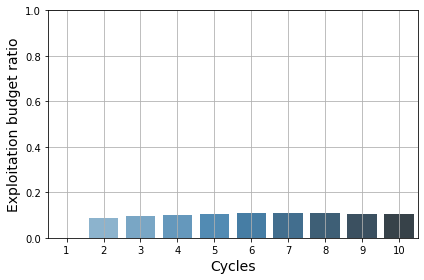

In [18]:
ax = sns.barplot(x=list(range(len(exploitation_prefixes_ratio))), y=exploitation_prefixes_ratio, palette="Blues_d")

ax.set_xlabel("Cycles", fontsize=14)
ax.set_ylabel("Exploitation budget ratio", fontsize=14)
ax.set(ylim=(0, 1))

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 10)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(1, 11)))
ax.grid()

plt.tight_layout()
plt.savefig("../resources/figures/exploitation_fraction_budget.pdf")
plt.show()